# Polaris

In [1]:
import aplpy
from astropy.io import fits
%pylab inline

Populating the interactive namespace from numpy and matplotlib


INFO: Auto-setting vmin to -1.796e+01 [aplpy.core]
INFO: Auto-setting vmax to  5.668e+01 [aplpy.core]


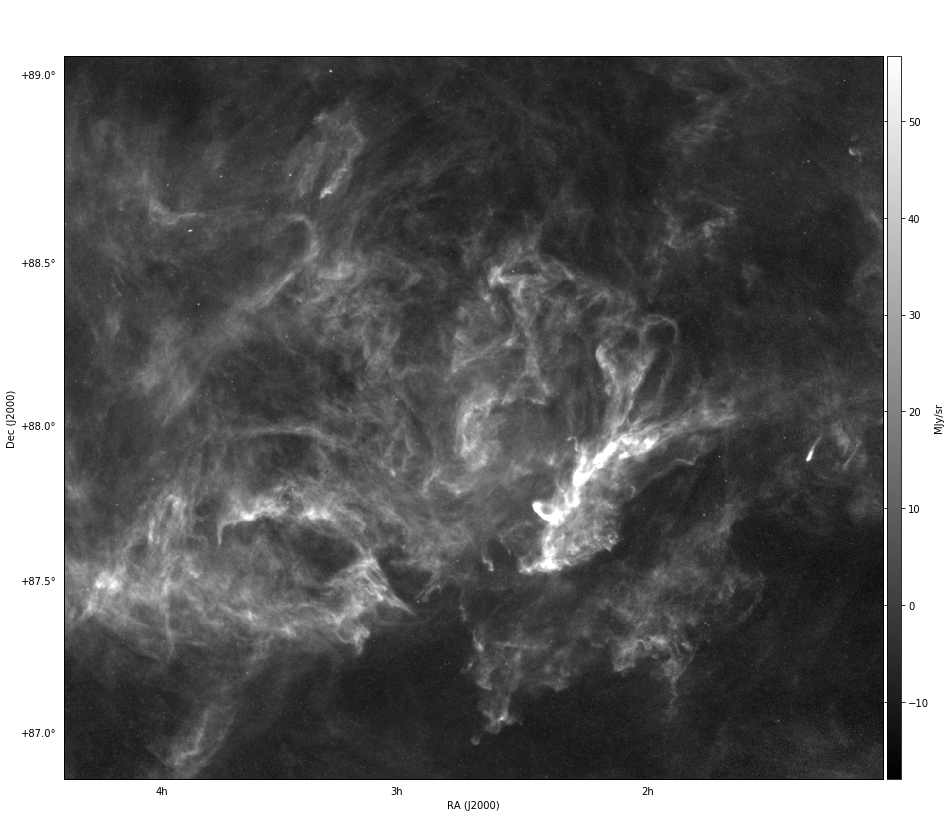

In [15]:
fig_all = plt.figure(1, figsize=(15,15))
figfile = '/user/workdir/robitaij/fil2star/Herschel/Gould_Belt/polaris-250_cut.fits'
fig = aplpy.FITSFigure(figfile,figure=fig_all)
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_xformat('hh')
fig.tick_labels.set_yformat('dd.d')
fig.ticks.set_xspacing(0.25)  # degrees
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
#fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')
fig.colorbar.set_axis_label_text(r'MJy/sr')

In [16]:
from bokeh.plotting import figure as figbok
from bokeh.io import output_notebook
from bokeh.io import show as showbok
output_notebook()

from astropy import wcs
from powspec import powspec
from wavan import fan_trans, apodize, padding, depad
from rebin import congrid
from gauss_beam import gauss_beam

Loading BokehJS ...

In [17]:
#Read map
HDU = fits.open(figfile)
im = HDU[0].data
header = HDU[0].header

In [ ]:
#Resolution in arcmin
reso = HDU[0].header['CDELT2'] * 60.

na = im.shape[1]
nb = im.shape[0]
imzm = im - np.mean(im)

#Apodization

tapper = apodize(nb,na,0.98)
imt = imzm *tapper
imr = padding(imt,1800,1800)

#Fourier power spectrum
tab_k, spec_k = powspec(imr, reso=reso)

#Beam Power spectrum
FWHM = 18.2 / (60.*reso)  #Beam size at 500 micron
beam = gauss_beam(FWHM,im.shape[0],im.shape[1],FWHM=True)
beam = gauss_beam(FWHM,1800,1800,FWHM=True)
tab_k, spec_beam = powspec(beam, reso=reso)
spec_beamn = spec_beam/spec_beam[0]  #Spectrum normalisation
Bwt, BS11a, Bwav_k, BS1a, Bq = fan_trans(beam, reso=reso, q=0, qdyn=False)
del Bwt,BS11a,Bq
BS1an = BS1a / BS1a[3]

#Plot Fourier power spectrum
Tools='pan,box_zoom,reset,save,hover'
f = figbok( x_axis_label="k [arcmin^-1]", x_axis_type="log", \
           y_axis_label="P[k]", y_axis_type="log", tools=Tools)
f.line(tab_k, spec_k/spec_beamn, legend='Fourier')

#Set a list of q
q=[]
#q[0:4]=[1.4]*5
#q[5:25]=[2.5]*20
q=[2.5]*25
print q

#Wavelet power spectrum
#wt, S11a, wav_k, S1a, q = fan_trans(imzm, reso=reso, q=q, qdyn=True)
wt, S11a, wav_k, S1a, q = fan_trans(imzm, reso=reso, q=q, qdyn=True, apodize= 0.98, arrdim = np.array([1800,1800]))

S1an = np.copy(S1a)

S1an[0,3:] = S1a[0,3:]/BS1an[3:]
S1an[1,3:] = S1a[1,3:]/BS1an[3:]
S1an[2,3:] = S1a[2,3:]/BS1an[3:]

f.diamond(wav_k, S1an[0,:], legend='Wavelet',color='black',line_width=5)
f.triangle(wav_k, S1an[1,:], legend='Coherent',color='blue',line_width=5)
f.square(wav_k, S1an[2,:], legend='Gaussian',color='red',line_width=5)

#Power law fit
coef = np.polyfit(np.log(wav_k[7:21]),np.log(S1an[2,7:21]),deg=1)
yfit = np.exp(coef[1])*wav_k**coef[0]

coef2 = np.polyfit(np.log(wav_k[14:21]),np.log(S1an[1,14:21]),deg=1)
yfit2 = np.exp(coef2[1])*wav_k**coef2[0]

print "Power law = ", coef[0],coef2[0]

f.line(wav_k, yfit, legend='Fit', line_dash='dashed')
f.line(wav_k, yfit2, line_dash='dashed')

showbok(f)

[2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5]
1800 1800


/user/homedir/robitaij/pywavan/wavan.py:125: RuntimeWarning: invalid value encountered in less_equal
  indx = np.where((module <= tresh) & (module > 0.))
/user/homedir/robitaij/pywavan/wavan.py:125: RuntimeWarning: invalid value encountered in greater
  indx = np.where((module <= tresh) & (module > 0.))
/user/homedir/robitaij/pywavan/wavan.py:127: RuntimeWarning: invalid value encountered in double_scalars
  Sigtresh = np.sum(temoin)/(temoin.shape[0])


In [12]:
np.save('/user/workdir/robitaij/fil2star/Herschel/Gould_Belt/analysis/Polaris_Bwav_k.npy',Bwav_k)
np.save('/user/workdir/robitaij/fil2star/Herschel/Gould_Belt/analysis/Polaris_BS1a.npy',BS1a)
np.save('/user/workdir/robitaij/fil2star/Herschel/Gould_Belt/analysis/Polaris_wt.npy',wt)
np.save('/user/workdir/robitaij/fil2star/Herschel/Gould_Belt/analysis/Polaris_S11a.npy',S11a)
np.save('/user/workdir/robitaij/fil2star/Herschel/Gould_Belt/analysis/Polaris_wav_k.npy',wav_k)
np.save('/user/workdir/robitaij/fil2star/Herschel/Gould_Belt/analysis/Polaris_S1a.npy',S1a)
np.save('/user/workdir/robitaij/fil2star/Herschel/Gould_Belt/analysis/Polaris_q.npy',q)